## Chapter 5 - Support Vector Machines

SVMs are very powerful and versatile ML models, able to perform linear or nonlinear classification, regression and outlier detection.

### Linear SVM Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [2]:
# Ingest
iris_dataset = datasets.load_iris()
X = pd.DataFrame(iris_dataset['data'], columns=iris_dataset['feature_names'])
y = pd.Series(iris_dataset['target'])
y_names = pd.Series(iris_dataset['target_names'][i] for i in y)

df = X.join(pd.DataFrame(y_names, columns=['y_name']))
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_name
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
# For testing
# display(X.head(2))
# display(y.head(2))
# display(y_names.head(2))

Using the Iris dataset, it is clear that these 2 classes are easily linearly separable. Ideally, the line stays as far away from the closest training instances. It aims to fit the widest possible street between the classes. This is called large margin classification.

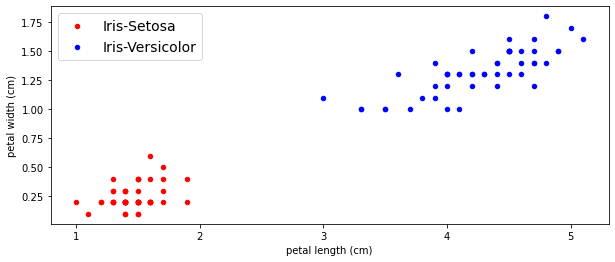

In [4]:
# Plotting 2 classes
fig, ax = plt.subplots(figsize=(10,4))
df[df.y_name=='setosa'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='red')
df[df.y_name=='versicolor'].plot(kind='scatter', x='petal length (cm)', y='petal width (cm)', ax=ax, color='blue')
ax.legend(['Iris-Setosa', 'Iris-Versicolor'], fontsize=14)
plt.show()

Hard margin classification is when strict rules are imposed and all instances be off the street and on the right side. In soft margin classification, the objective is to find a good balance between keeping the street as large as possible, and limiting wrongly classified instances.

This can be controlled using the `C` parameter. A high `C` value makes fewer wrong classifications but ends up with a smaller margin, while a larger `C` results in a larger street but many instances end up on the street. Smaller `C` improves on generalisation.

In [5]:
expt1_X = df[['petal length (cm)', 'petal width (cm)']]
expt1_y = y==2

In [6]:
# Preprocessing
scaler = StandardScaler()
expt1_X_sc = scaler.fit_transform(expt1_X)

# Train
clf = LinearSVC(C=1, loss='hinge')
clf.fit(expt1_X_sc, expt1_y)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [7]:
# Predict
X_test = [[5.5,1.7]]
X_test_scl = scaler.transform(X_test)
clf.predict(X_test_scl)

array([ True])